In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union, nearest_points
from shapely import wkt

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [2]:
from my_osm import get_osm_data
from my_area_stats import val_per_area

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'The Hague'
country = 'NLD'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'
local_crs = 'EPSG:28992'
place_extra = 0

In [5]:
trip_distances = [300, 500, 800]
buffer = max(trip_distances)

children = True
osm_schools = False

# Load data

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
if place_extra:
    place['geometry'] = place.buffer(place_extra, join_style=2)
extent = place.buffer(buffer, join_style=2)

## load network

In [7]:
G = ox.load_graphml(os.path.join(output_folder, sub_folder, 'G.graphml'))
G = ox.project_graph(G, to_crs=local_crs)

In [8]:
nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
edges = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True)
edges.reset_index(drop=True, inplace=True)

In [9]:
# https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
    
voronoi_crs = 'epsg:3395'

extent_for_voronoi = cascaded_union(extent.to_crs(voronoi_crs).geometry)
points_for_voronoi = points_to_coords(gpd.clip(nodes.to_crs(voronoi_crs), extent.to_crs(voronoi_crs)).geometry)

voronoi_polygons, pts = voronoi_regions_from_coords(points_for_voronoi, extent_for_voronoi)

voronoi_gdf = gpd.GeoDataFrame(
    index=list(voronoi_polygons.keys()), 
    geometry=list(voronoi_polygons.values()),
    crs=voronoi_crs)

voronoi_gdf = voronoi_gdf.to_crs(local_crs)
voronoi_gdf['vor_index'] = voronoi_gdf.index

## Load origins

In [10]:
origins = gpd.read_file(os.path.join(output_folder, sub_folder, 'residences_population.geojson'))
origins.crs = local_crs
origins['original_geometry'] = origins.geometry
origins = origins.set_geometry(origins.geometry.centroid)

In [11]:
origins['weight_pop'] = origins['pop_count'].astype(float)
if country == 'NLD' and children:
    origins['weight_cld'] = origins['cld_count'].astype(float)
    origins['weight_adl'] = origins['adl_count'].astype(float)
origins['X'] = origins.geometry.x
origins['Y'] = origins.geometry.y
origins['_geom'] = origins.geometry

In [12]:
cols = ['X', 'Y', '_geom', 'weight_pop']
if country == 'NLD' and children:
    cols.extend(['weight_cld', 'weight_adl'])
origins = gpd.GeoDataFrame(origins[cols].copy(), geometry='_geom')

In [13]:
# sum values in voronoi polgyons
    
if country == 'NLD' and children:
    voronoi_gdf_origins = voronoi_gdf.copy()
    for col in ['weight_pop', 'weight_cld', 'weight_adl']:
        voronoi_gdf_origins = val_per_area(voronoi_gdf_origins, 'vor_index', origins, modes=['sum', 'mean', 'count'], value_col=col)
    origins_simpl = gpd.sjoin(nodes, voronoi_gdf_origins, how='left', predicate='intersects')
    origins_simpl = origins_simpl[(origins_simpl['weight_pop_sum']>0) | (origins_simpl['weight_cld_sum']>0) | (origins_simpl['weight_adl_sum']>0)]

else:
    voronoi_gdf_origins = val_per_area(voronoi_gdf, 'vor_index', origins, modes=['sum'], value_col='weight_pop')
    voronoi_gdf_origins = voronoi_gdf_origins[voronoi_gdf_origins['weight_pop_sum']>0]
    origins_simpl = gpd.sjoin(nodes, voronoi_gdf_origins, how='left', predicate='intersects')    

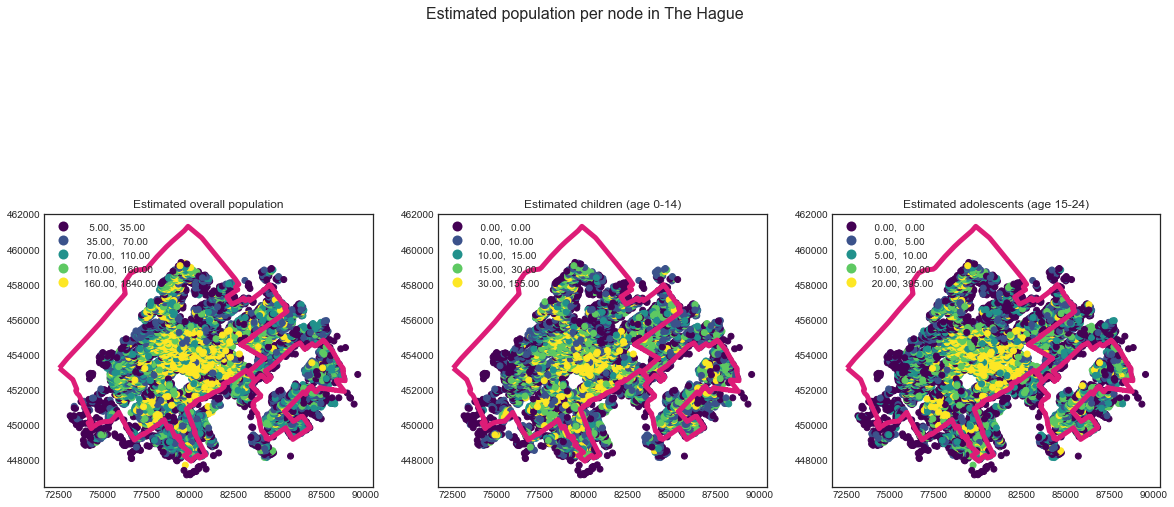

In [14]:
if country == 'NLD' and children:
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
    fig.suptitle('Estimated population per node in {}'.format(place_name), fontsize=16)

    origins_simpl.plot(ax=axs[0], column='weight_pop_sum', cmap='viridis', scheme='quantiles', legend=True)
    place.plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5)
    axs[0].set_title('Estimated overall population')
    
    origins_simpl.plot(ax=axs[1], column='weight_cld_sum', cmap='viridis', scheme='quantiles', legend=True)
    place.plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5)
    axs[1].set_title('Estimated children (age 0-14)')
    
    origins_simpl.plot(ax=axs[2], column='weight_adl_sum', cmap='viridis', scheme='quantiles', legend=True)
    place.plot(ax=axs[2], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5)
    axs[2].set_title('Estimated adolescents (age 15-24)')

    plt.show()
    
else:
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
    fig.suptitle('Estimated population per node in {}'.format(place_name), fontsize=16)

    origins_simpl.plot(ax=axs, column='weight_pop_sum', cmap='viridis', scheme='quantiles', legend=True)
    place.plot(ax=axs, facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5)
    axs.set_title('Estimated overall population')
    
    plt.show()

In [15]:
print("After simplifying origins, {} out of {} origins remain ({}%).".format(len(origins_simpl), len(origins), (round(100*len(origins_simpl)/len(origins), 1))))

After simplifying origins, 6464 out of 6766 origins remain (95.5%).


In [16]:
origins_simpl['X'] = origins_simpl.geometry.x
origins_simpl['Y'] = origins_simpl.geometry.y
origins_simpl['weight_pop'] = origins_simpl.weight_pop_sum

if country == 'NLD' and children:
    origins_simpl['weight_cld'] = origins_simpl.weight_cld_sum
    origins_simpl['weight_adl'] = origins_simpl.weight_adl_sum

## Load destinations

### Educational

In [17]:
destinations_children = gpd.read_file(os.path.join(output_folder, sub_folder, 'education_children.geojson'))
destinations_children.crs = local_crs
destinations_children = destinations_children.set_geometry(destinations_children.geometry.centroid)

In [18]:
destinations_children['weight'] = 1
destinations_children['X'] = destinations_children.geometry.x
destinations_children['Y'] = destinations_children.geometry.y
destinations_children['_geom'] = destinations_children.geometry

In [19]:
cols = ['X', 'Y', '_geom', 'weight']
destinations_children = gpd.GeoDataFrame(destinations_children[cols].copy(), geometry='_geom')

In [20]:
destinations_adolescents = gpd.read_file(os.path.join(output_folder, sub_folder, 'education_adolescents.geojson'))
destinations_adolescents.crs = local_crs
destinations_adolescents = destinations_adolescents.set_geometry(destinations_adolescents.geometry.centroid)

In [21]:
destinations_adolescents['weight'] = 1
destinations_adolescents['X'] = destinations_adolescents.geometry.x
destinations_adolescents['Y'] = destinations_adolescents.geometry.y
destinations_adolescents['_geom'] = destinations_adolescents.geometry

In [22]:
cols = ['X', 'Y', '_geom', 'weight']
destinations_adolescents = gpd.GeoDataFrame(destinations_adolescents[cols].copy(), geometry='_geom')

In [23]:
# sum values in voronoi polgyons
voronoi_dest_children = val_per_area(voronoi_gdf, 'vor_index', destinations_children, modes=['sum'], value_col='weight')
voronoi_dest_children = voronoi_dest_children[voronoi_dest_children['weight_sum']>0]
destinations_children_simpl = gpd.sjoin(nodes, voronoi_dest_children, how='inner', predicate='intersects')   

voronoi_dest_adolescents = val_per_area(voronoi_gdf, 'vor_index', destinations_adolescents, modes=['sum'], value_col='weight')
voronoi_dest_adolescents = voronoi_dest_adolescents[voronoi_dest_adolescents['weight_sum']>0]
destinations_adolescents_simpl = gpd.sjoin(nodes, voronoi_dest_adolescents, how='inner', predicate='intersects')  

In [24]:
print("After simplifying educational destinations for children, {} out of {} destinations remain ({} %).".format(len(destinations_children_simpl), len(destinations_children), (round(100*len(destinations_children_simpl)/len(destinations_children), 1))))

After simplifying educational destinations for children, 164 out of 164 destinations remain (100.0 %).


In [25]:
destinations_children_simpl['X'] = destinations_children_simpl.geometry.x
destinations_children_simpl['Y'] = destinations_children_simpl.geometry.y
destinations_children_simpl['weight'] = destinations_children_simpl.weight_sum

In [26]:
destinations_children_simpl.reset_index(drop=True, inplace=True)

In [27]:
print("After simplifying edu destinations for adolescents, {} out of {} destinations remain ({} %).".format(len(destinations_adolescents_simpl), len(destinations_adolescents), (round(100*len(destinations_adolescents_simpl)/len(destinations_adolescents), 1))))

After simplifying edu destinations for adolescents, 81 out of 85 destinations remain (95.3 %).


In [28]:
destinations_adolescents_simpl['X'] = destinations_adolescents_simpl.geometry.x
destinations_adolescents_simpl['Y'] = destinations_adolescents_simpl.geometry.y
destinations_adolescents_simpl['weight'] = destinations_adolescents_simpl.weight_sum

In [29]:
destinations_adolescents_simpl.reset_index(drop=True, inplace=True)

/Users/roosteeuwen/opt/anaconda3/envs/greenspaces/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


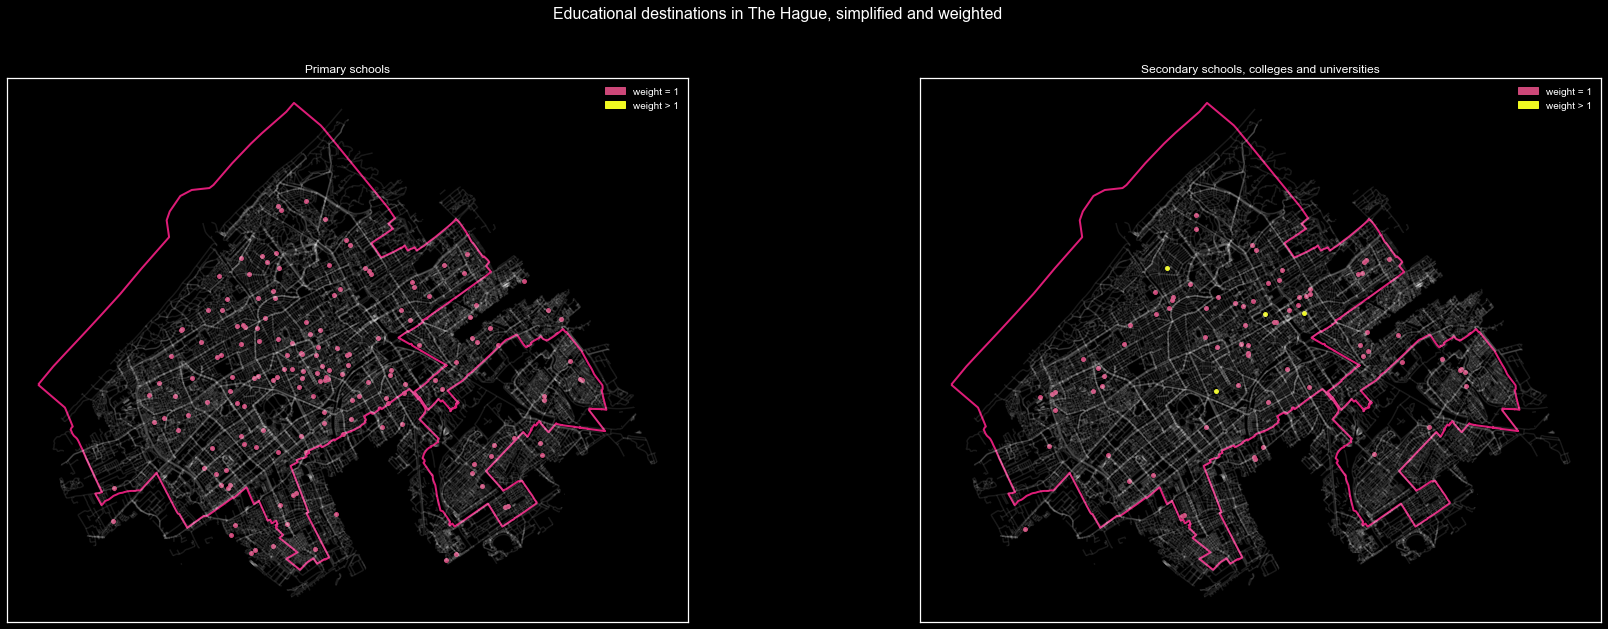

In [30]:
style.use('dark_background')

handles = [
    mpatches.Patch(color='#CC4778', label='weight = 1'),
    mpatches.Patch(color='#F0F921', label='weight > 1')]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharex=True, sharey=True)
fig.suptitle('Educational destinations in {}, simplified and weighted'.format(place_name), fontsize=16)

edges.plot(ax=axs[0], color='white', alpha=0.1)
destinations_children_simpl[destinations_children_simpl['weight']==1].plot(ax=axs[0], color='#CC4778', markersize=15)
destinations_children_simpl[destinations_children_simpl['weight']>1].plot(ax=axs[0], color='#F0F921', markersize=15)
place.plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[0].set_title('Primary schools')

edges.plot(ax=axs[1], color='white', alpha=0.1)
destinations_adolescents_simpl[destinations_adolescents_simpl['weight']==1].plot(ax=axs[1], color='#CC4778', markersize=15)
destinations_adolescents_simpl[destinations_adolescents_simpl['weight']>1].plot(ax=axs[1], color='#F0F921', markersize=15)
place.plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[1].set_title('Secondary schools, colleges and universities')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.legend(handles=handles)

plt.show()

#  Store output data

In [31]:
output_sub_folder = os.path.join(output_folder, sub_folder)

In [32]:
output_file = os.path.join(output_sub_folder, 'origins')
cols = ['weight_pop', 'weight_cld', 'weight_adl', 'X', 'Y']
origins_simpl[cols].to_csv(output_file+'.csv', sep='\t', index=False)
os.rename(output_file+'.csv', output_file+'.tsv')

In [33]:
output_file = os.path.join(output_sub_folder, 'destinations_children')
cols = ['weight', 'X', 'Y']
destinations_children_simpl[cols].to_csv(output_file+'.csv', sep='\t', index=False)
os.rename(output_file+'.csv', output_file+'.tsv')

In [34]:
output_file = os.path.join(output_sub_folder, 'destinations_adolescents')
cols = ['weight', 'X', 'Y']
destinations_adolescents_simpl[cols].to_csv(output_file+'.csv', sep='\t', index=False)
os.rename(output_file+'.csv', output_file+'.tsv')

In [35]:
output_file = os.path.join(output_sub_folder, 'network.dxf')
edges.geometry.to_file(output_file, driver='DXF')